In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import genfromtxt
import pandas as pd
from collections import Counter
import itertools
import json

In [2]:
df = pd.read_csv('annotations.csv', sep=',', low_memory=False)

fine_labels = df.columns[12:41]
coarse_labels = df.columns[70:]

In [ ]:
def count_labels(labels, df):
    # map from label name to position
    label_to_index = {label: index for index, label in enumerate(labels)}
    counts = Counter()
    for _, row in df.iterrows():
        # get index of elements equal to 1
        labels_for_instance = row[row == 1].index.to_numpy()
        # get all pairs of those labels
        pairs = set(itertools.combinations(labels_for_instance, 2))
        # update the counts
        counts.update(pairs)
    matrix = np.zeros([labels.shape[0], labels.shape[0]])
    for (label1, label2), count in counts.items():
        i = label_to_index[label1]
        j = label_to_index[label2]
        # set count for both orderings
        matrix[i][j] = count
        matrix[j][i] = count
    return matrix


def heat_map(labels, matrix, size, font, title):
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.imshow(matrix)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    ax.set_xticklabels(labels, fontsize=font)
    ax.set_yticklabels(labels, fontsize=font)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matrix[i, j],
                           ha="center", va="center", color="w", fontsize=font/2)

    ax.set_title(title, fontsize=font)

    plt.show()
    
def get_agreement(labels, df):
    labels_list = labels.tolist()
    labels_list.append('audio_filename')
    filtered_df = df[labels_list]
    label_to_index = {label: index for index, label in enumerate(labels)}
    matrix = np.zeros([labels.shape[0], labels.shape[0]])
    for pair in set(itertools.combinations(labels, 2)):
        agreement = {}
        for _, row in filtered_df[filtered_df[pair[0]] == 1][filtered_df[pair[1]] == 1].iterrows():
            if row['audio_filename'] not in agreement:
                co_exist = 0
                not_co_exist = 0
                for _, annotation in filtered_df[filtered_df['audio_filename'] == row['audio_filename']].iterrows():
                    if annotation[pair[0]] == 1 and annotation[pair[1]] == 1:
                        co_exist += 1
                    else:
                        not_co_exist += 1
                agreement[row['audio_filename']] = (co_exist, not_co_exist)
        total_annotations = 0
        total_co_exist = 0
        for value in agreement.values():
            total_co_exist += value[0]
            total_annotations += value[0]
            total_annotations += value[1]
        i = label_to_index[pair[0]] 
        j = label_to_index[pair[1]]
        matrix[i][j] = total_co_exist / total_annotations
        matrix[j][i] = total_co_exist / total_annotations
    return matrix
        

def get_csv(labels, df, file_name):
    # map from label name to position
    label_to_index = {label: index for index, label in enumerate(labels)}
    counts = Counter()
    for _, row in df.iterrows():
        # get index of elements equal to 1
        labels_for_instance = row[row == 1].index.to_numpy()
        # get all pairs of those labels
        pairs = set(itertools.combinations(labels_for_instance, 2))
        # update the counts
        counts.update(pairs)
    result = []
    for (label1, label2), count in counts.items():
        result.append([label1, label2, count])
        result.append([label2, label1, count])
    pd.DataFrame(result).to_csv(file_name, header=['label1', 'label2', 'value'])
    return result

In [3]:
def get_co_occurrence_json(labels, df, filename):
    labels_list = labels.tolist()
    filtered_df = df[labels_list]
    label_to_index = {label: index for index, label in enumerate(labels)}
    counts = Counter()
    for _, row in filtered_df.iterrows():
        # get index of elements equal to 1
        labels_for_instance = row[row == 1].index.to_numpy()
        # get all pairs of those labels
        pairs = set(itertools.combinations(labels_for_instance, 2))
        # update the counts
        counts.update(pairs)
    result = []
    for (label1, label2), count in counts.items():
        result.append(
            {
                "label1": label1,
                "label2": label2,
                "count": count
            }
        )
        result.append(
            {
                "label1": label2,
                "label2": label1,
                "count": count
            }
        )
    with open(filename, "w") as outfile:
        json.dump(result, outfile)
    return

get_co_occurrence_json(fine_labels, df, "Co-Occurrence Heat Map.json")

In [7]:
def get_agreement_json(labels, df, filename):
    labels_list = labels.tolist()
    labels_list.append('audio_filename')
    filtered_df = df[labels_list]
    matrix = np.zeros([labels.shape[0], labels.shape[0]])
    result = []
    for pair in set(itertools.combinations(labels, 2)):
        agreement = {}
        for _, row in filtered_df[filtered_df[pair[0]] == 1][filtered_df[pair[1]] == 1].iterrows():
            if row['audio_filename'] not in agreement:
                co_exist = 0
                not_co_exist = 0
                for _, annotation in filtered_df[filtered_df['audio_filename'] == row['audio_filename']].iterrows():
                    if annotation[pair[0]] == 1 and annotation[pair[1]] == 1:
                        co_exist += 1
                    else:
                        not_co_exist += 1
                agreement[row['audio_filename']] = (co_exist, not_co_exist)
        total_annotations = 0
        total_co_exist = 0
        for value in agreement.values():
            total_co_exist += value[0]
            total_annotations += value[0]
            total_annotations += value[1]
        result.append(
            {
                "label1": pair[0],
                "label2": pair[1],
                "agreement": total_co_exist / total_annotations
            }
        )
        result.append(
            {
                "label1": pair[1],
                "label2": pair[0],
                "agreement": total_co_exist / total_annotations
            }
        )
    with open(filename, "w") as outfile:
        json.dump(result, outfile)
    return

get_agreement_json(fine_labels, df, "Agreement Heat Map.json")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [3]:
def get_instance_json(labels, df, filename):
    labels_list = labels.tolist()
    labels_list.append('audio_filename')
    filtered_df = df[labels_list]
    result = []
    for _, row in filtered_df.iterrows():
        instance = {}
        for label in labels_list:
            instance[label] = row[label]
        result.append(instance)
    with open(filename, "w") as outfile:
        json.dump(result, outfile)
    return

get_instance_json(fine_labels, df, "Instances.json")

In [18]:
get_csv(fine_labels, df[fine_labels], "Fine_Label_Count.csv")

[['7-1_person-or-small-group-talking_presence',
  '8-1_dog-barking-whining_presence',
  512],
 ['8-1_dog-barking-whining_presence',
  '7-1_person-or-small-group-talking_presence',
  512],
 ['5-1_car-horn_presence', '6-1_stationary-music_presence', 83],
 ['6-1_stationary-music_presence', '5-1_car-horn_presence', 83],
 ['7-3_large-crowd_presence', '7-4_amplified-speech_presence', 20],
 ['7-4_amplified-speech_presence', '7-3_large-crowd_presence', 20],
 ['7-1_person-or-small-group-talking_presence',
  '7-4_amplified-speech_presence',
  45],
 ['7-4_amplified-speech_presence',
  '7-1_person-or-small-group-talking_presence',
  45],
 ['7-1_person-or-small-group-talking_presence',
  '7-3_large-crowd_presence',
  87],
 ['7-3_large-crowd_presence',
  '7-1_person-or-small-group-talking_presence',
  87],
 ['7-1_person-or-small-group-talking_presence',
  '7-2_person-or-small-group-shouting_presence',
  437],
 ['7-2_person-or-small-group-shouting_presence',
  '7-1_person-or-small-group-talking_prese

In [4]:
fine_matrix = count_labels(fine_labels, df[fine_labels])

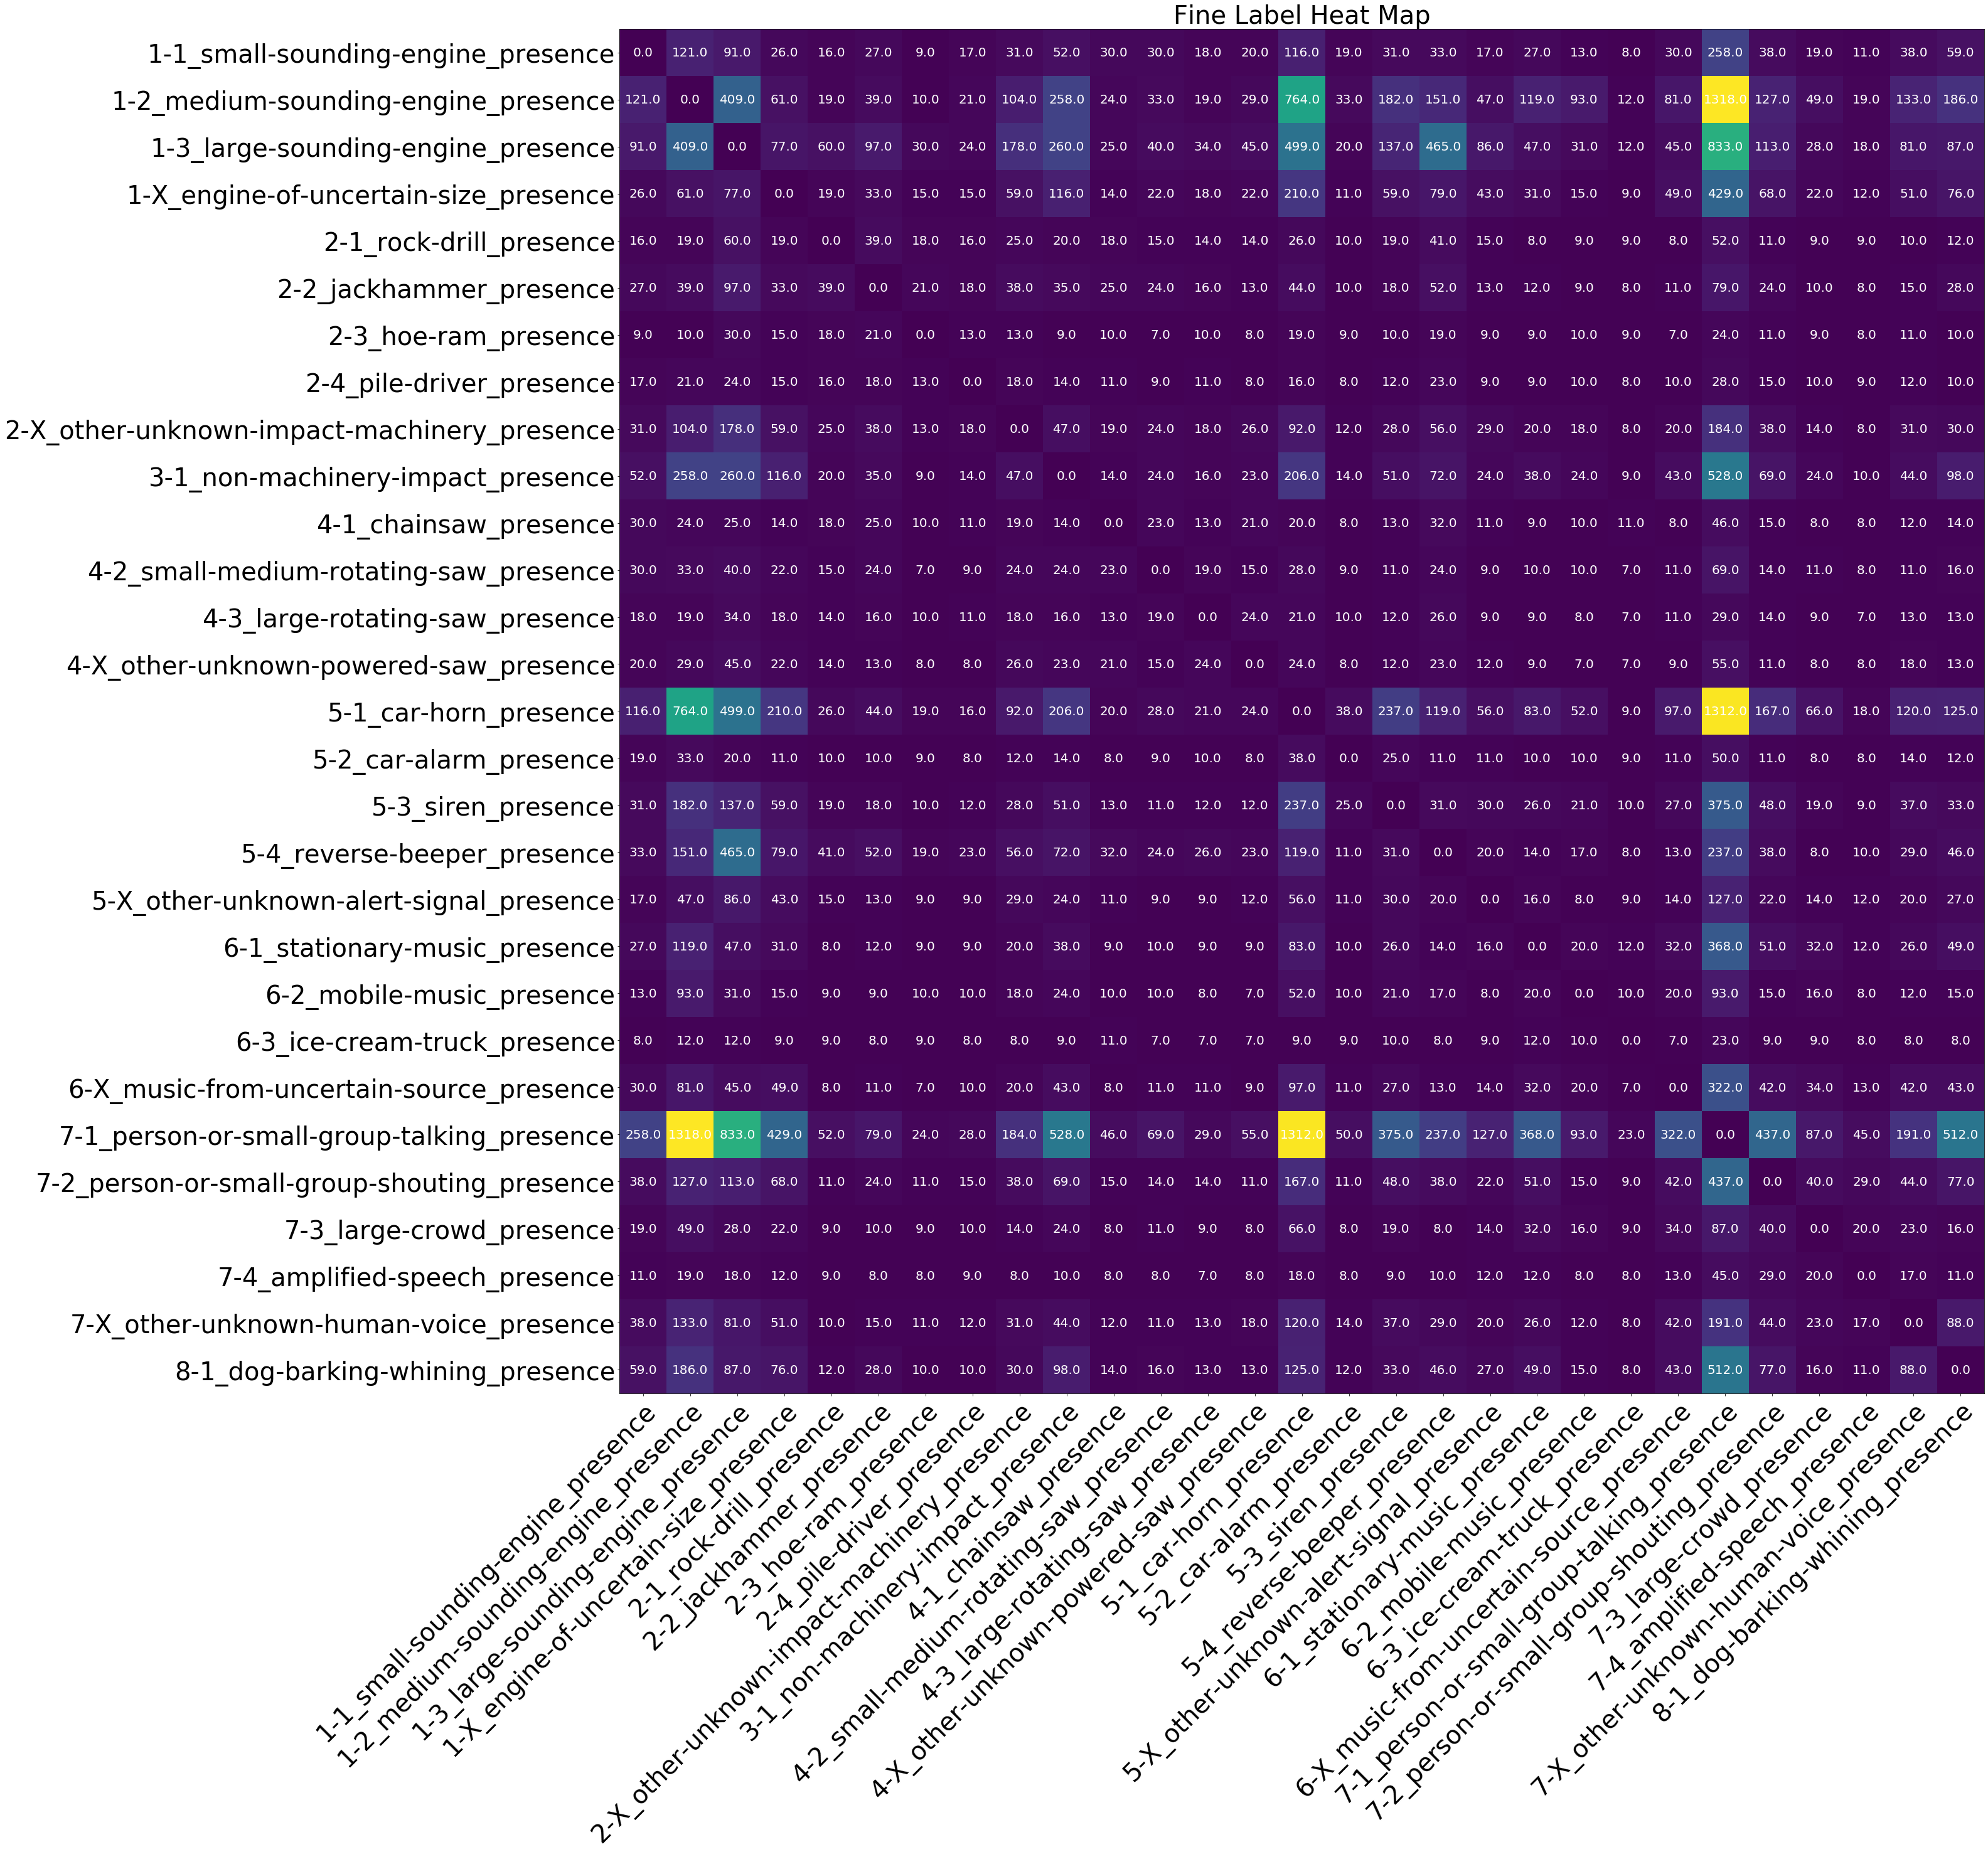

In [5]:
heat_map(fine_labels, fine_matrix, 40, 40, "Fine Label Heat Map")

In [7]:
coarse_matrix = count_labels(coarse_labels, df[coarse_labels])

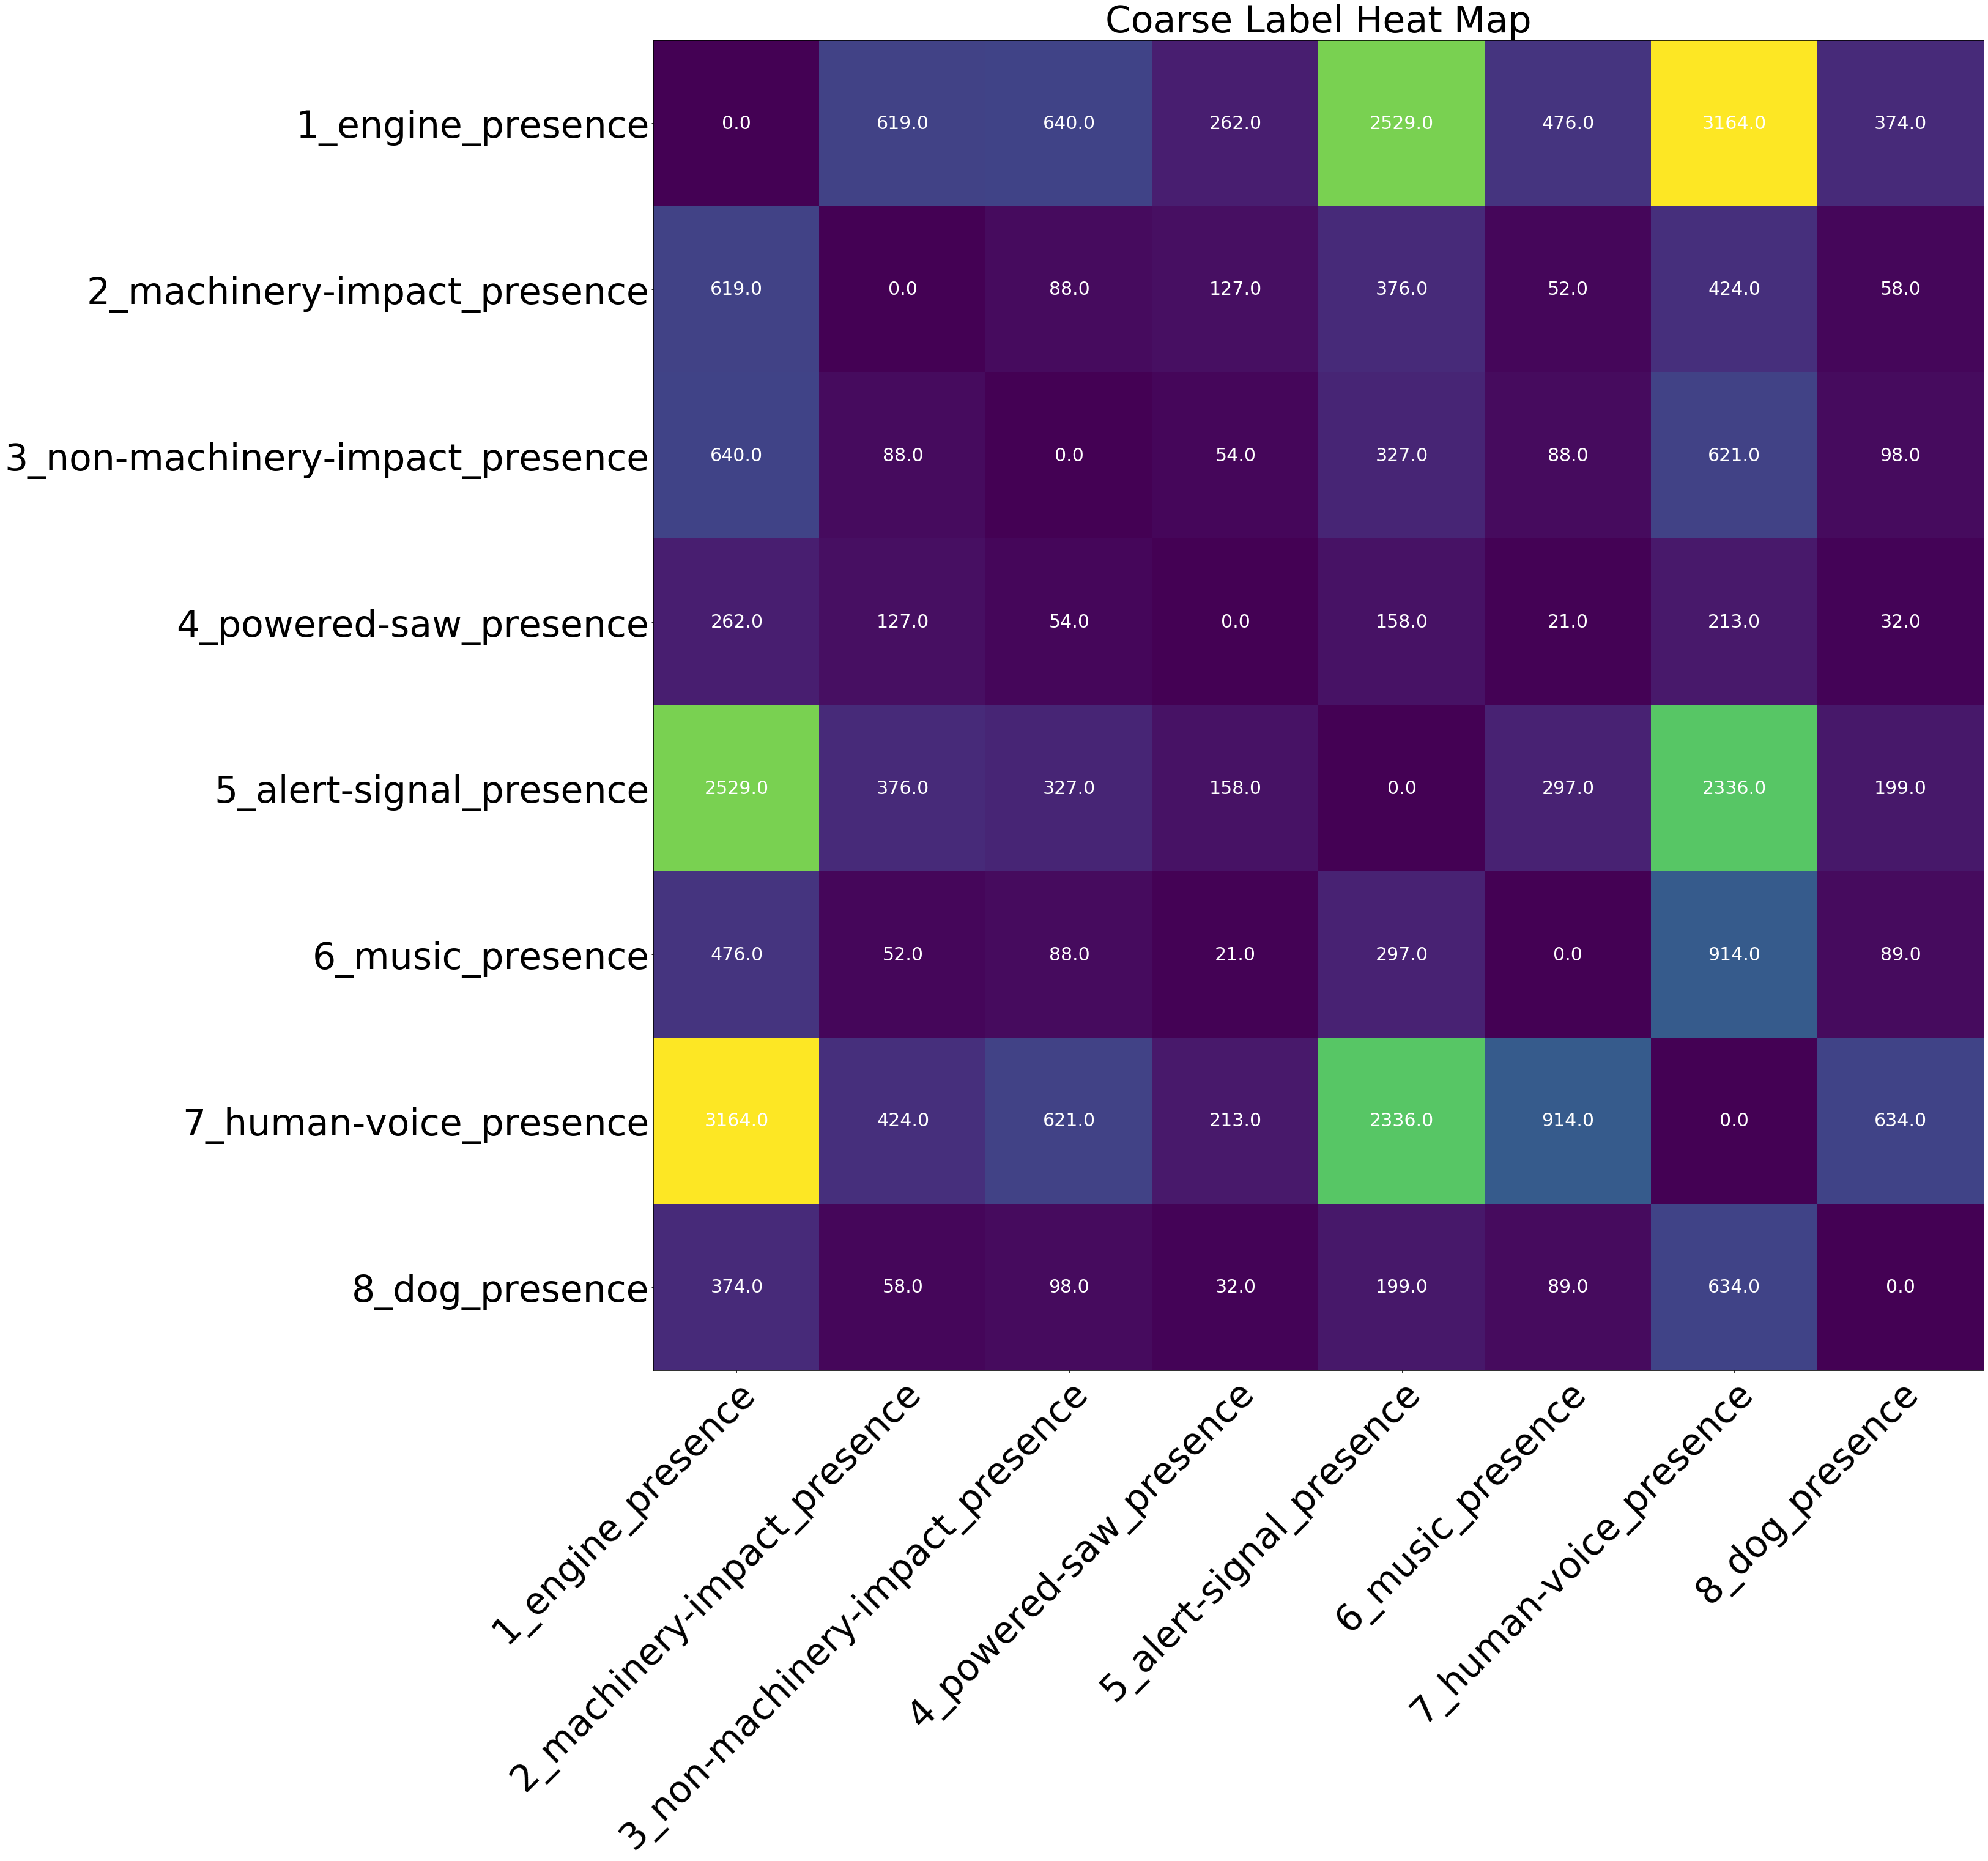

In [8]:
heat_map(coarse_labels, coarse_matrix, 40, 60, "Coarse Label Heat Map")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


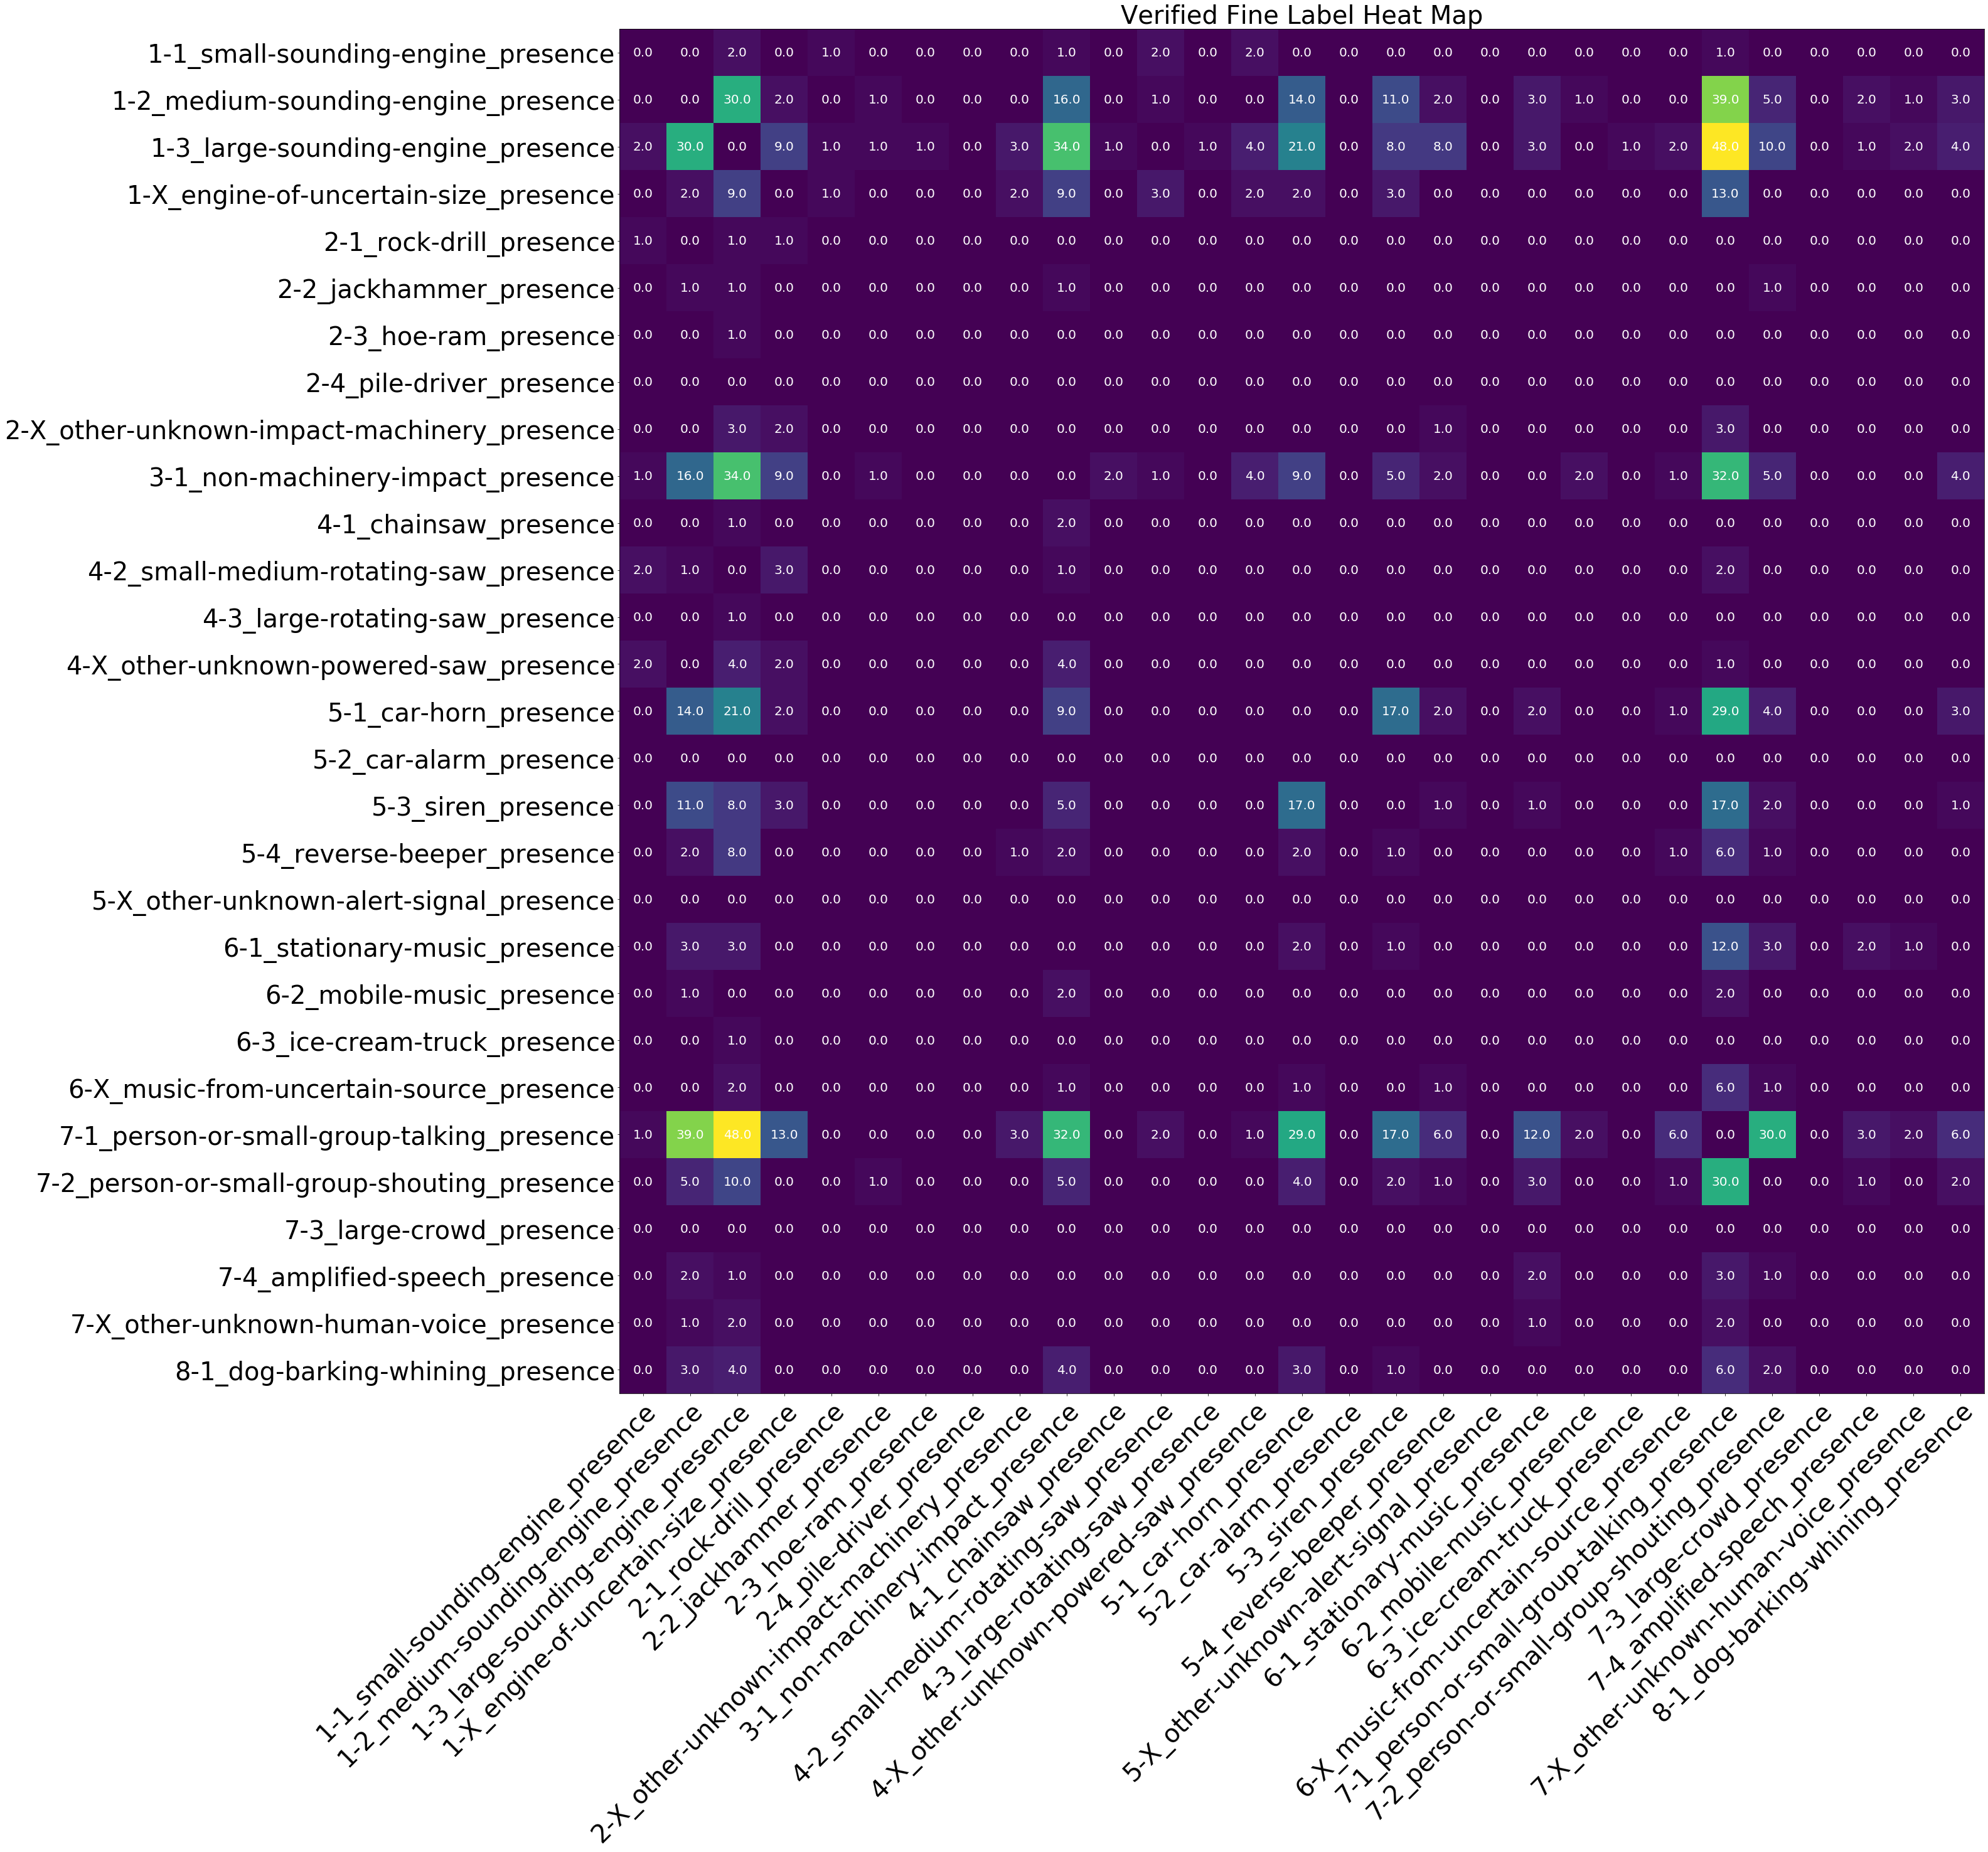

In [9]:
verified_df = df[df["split"] != "test"][df["annotator_id"] == 0]
verified_fine_matrix = count_labels(fine_labels, verified_df[fine_labels])
heat_map(fine_labels, verified_fine_matrix, 40, 40, "Verified Fine Label Heat Map")

In [10]:
coarse_agreement_matrix = get_agreement(coarse_labels, df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


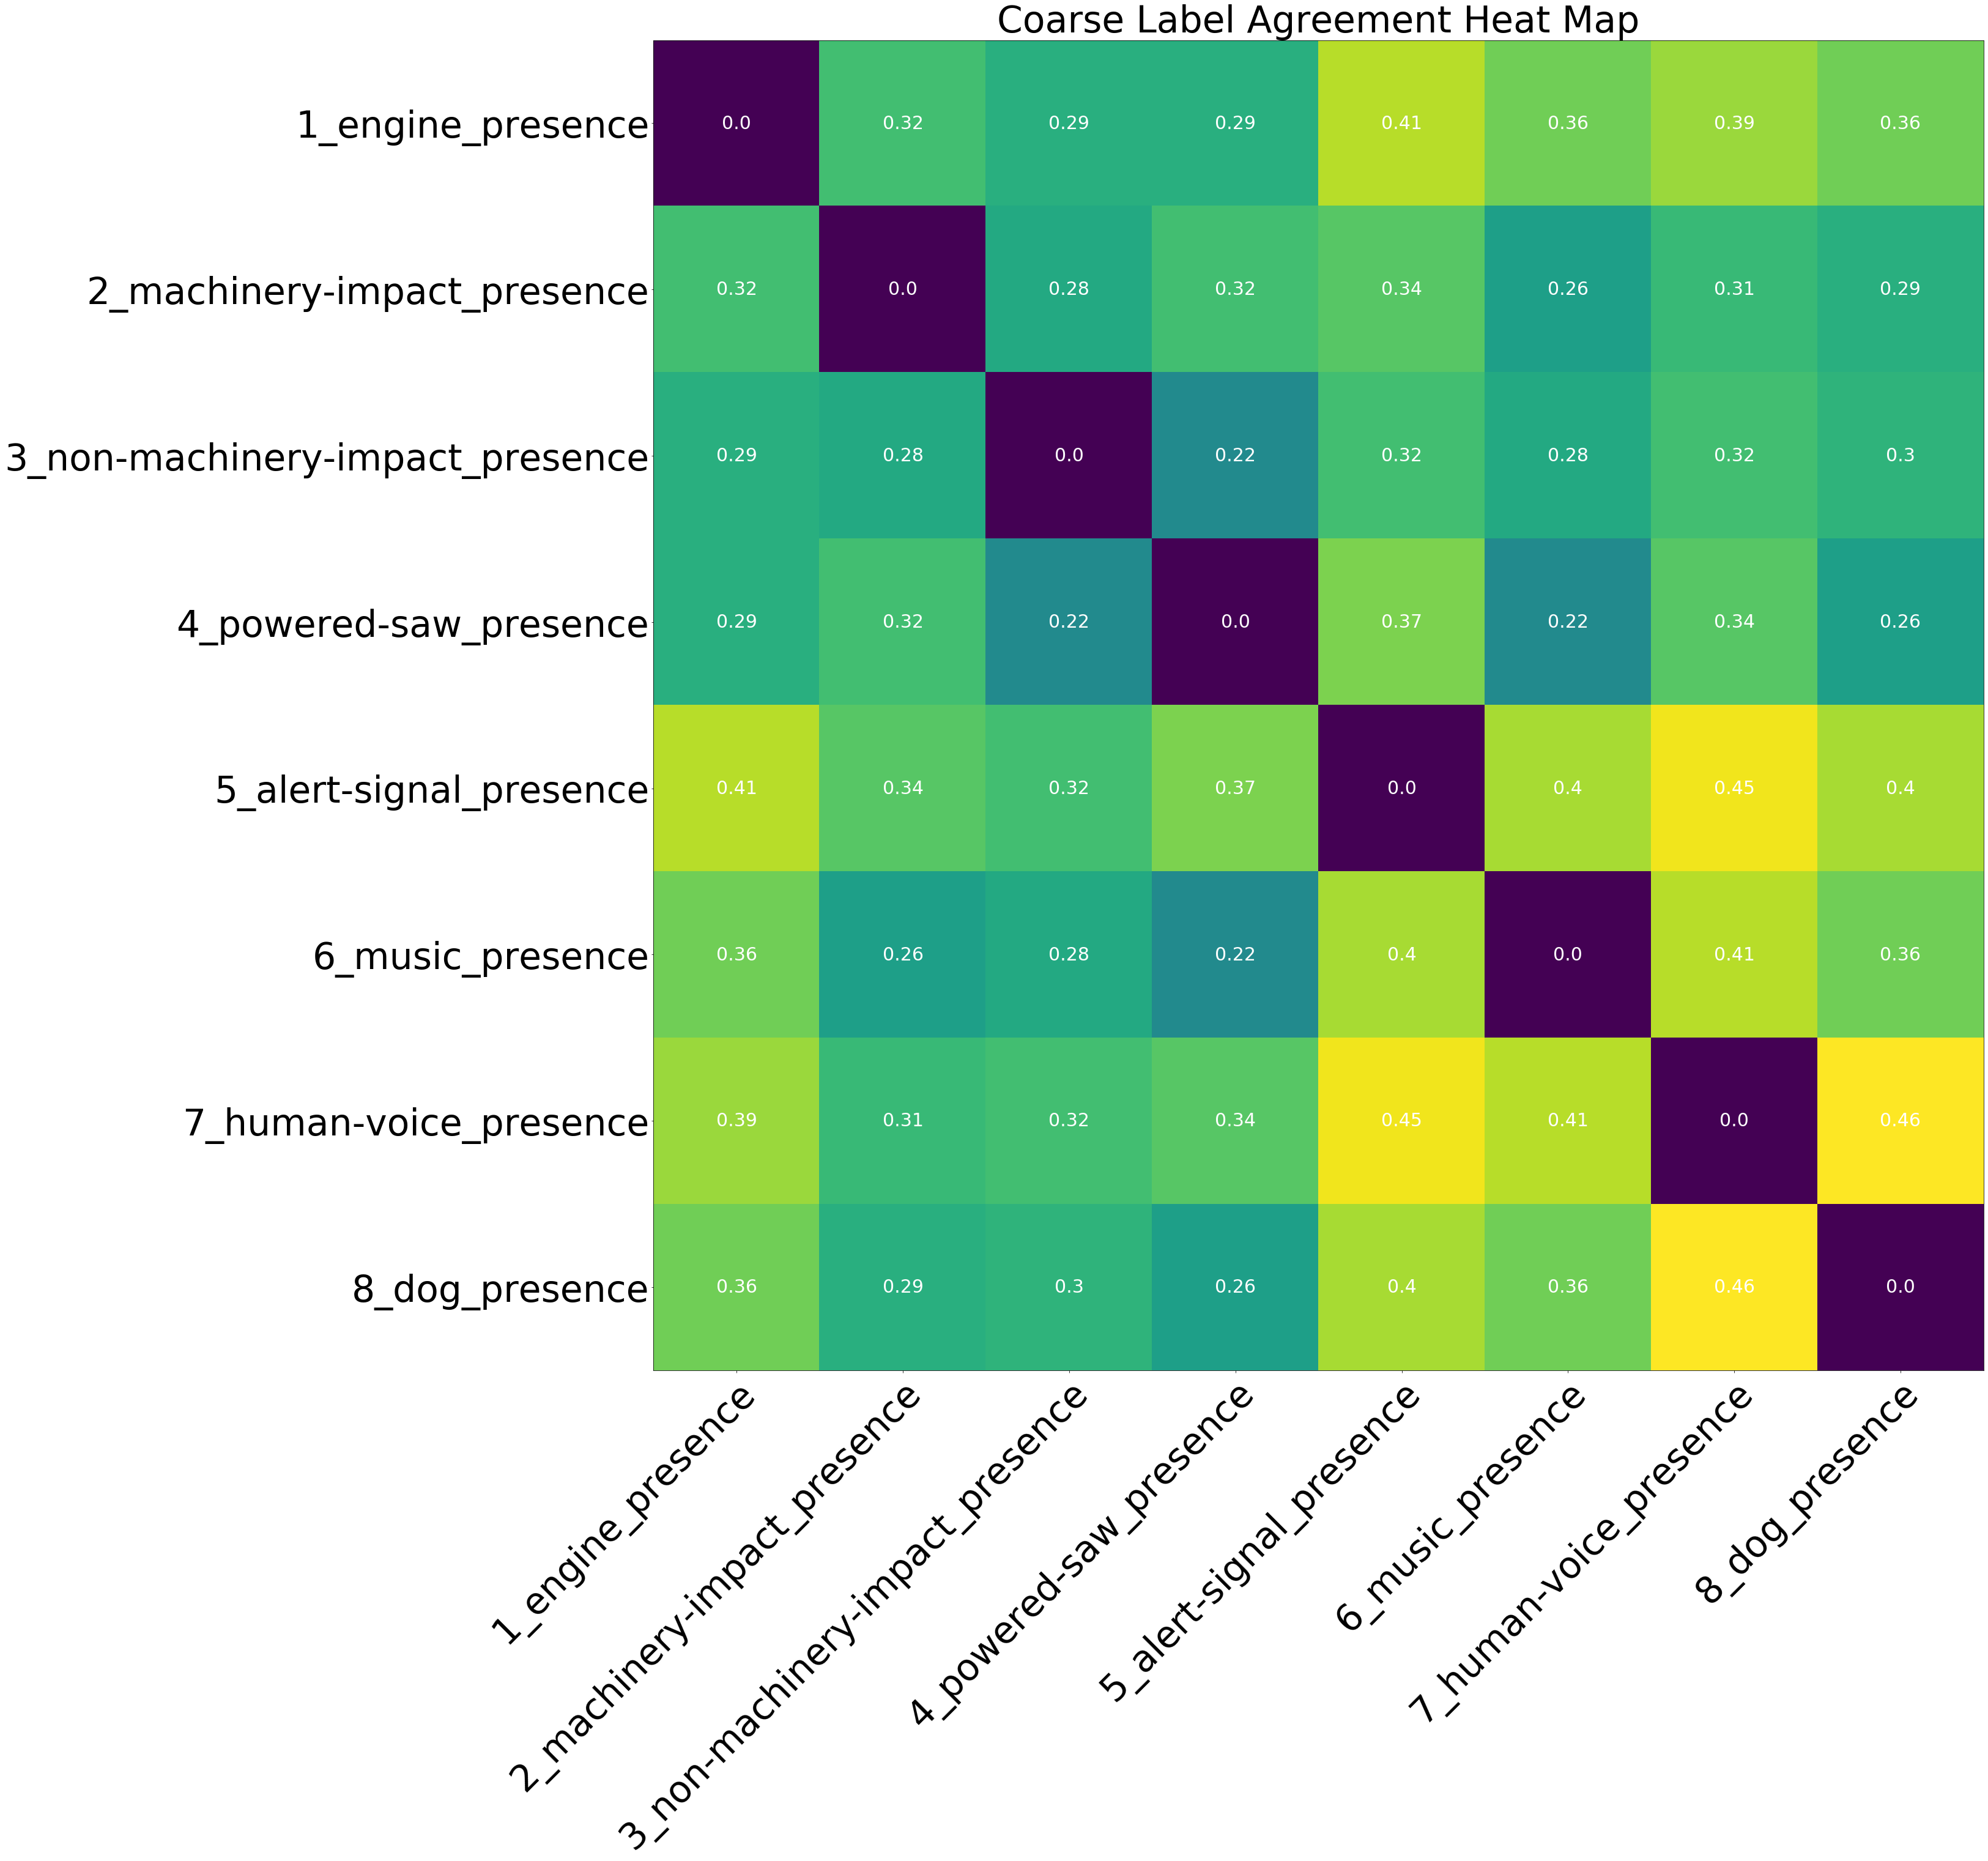

In [11]:
heat_map(coarse_labels, np.round(coarse_agreement_matrix, 2), 40, 60, "Coarse Label Agreement Heat Map")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


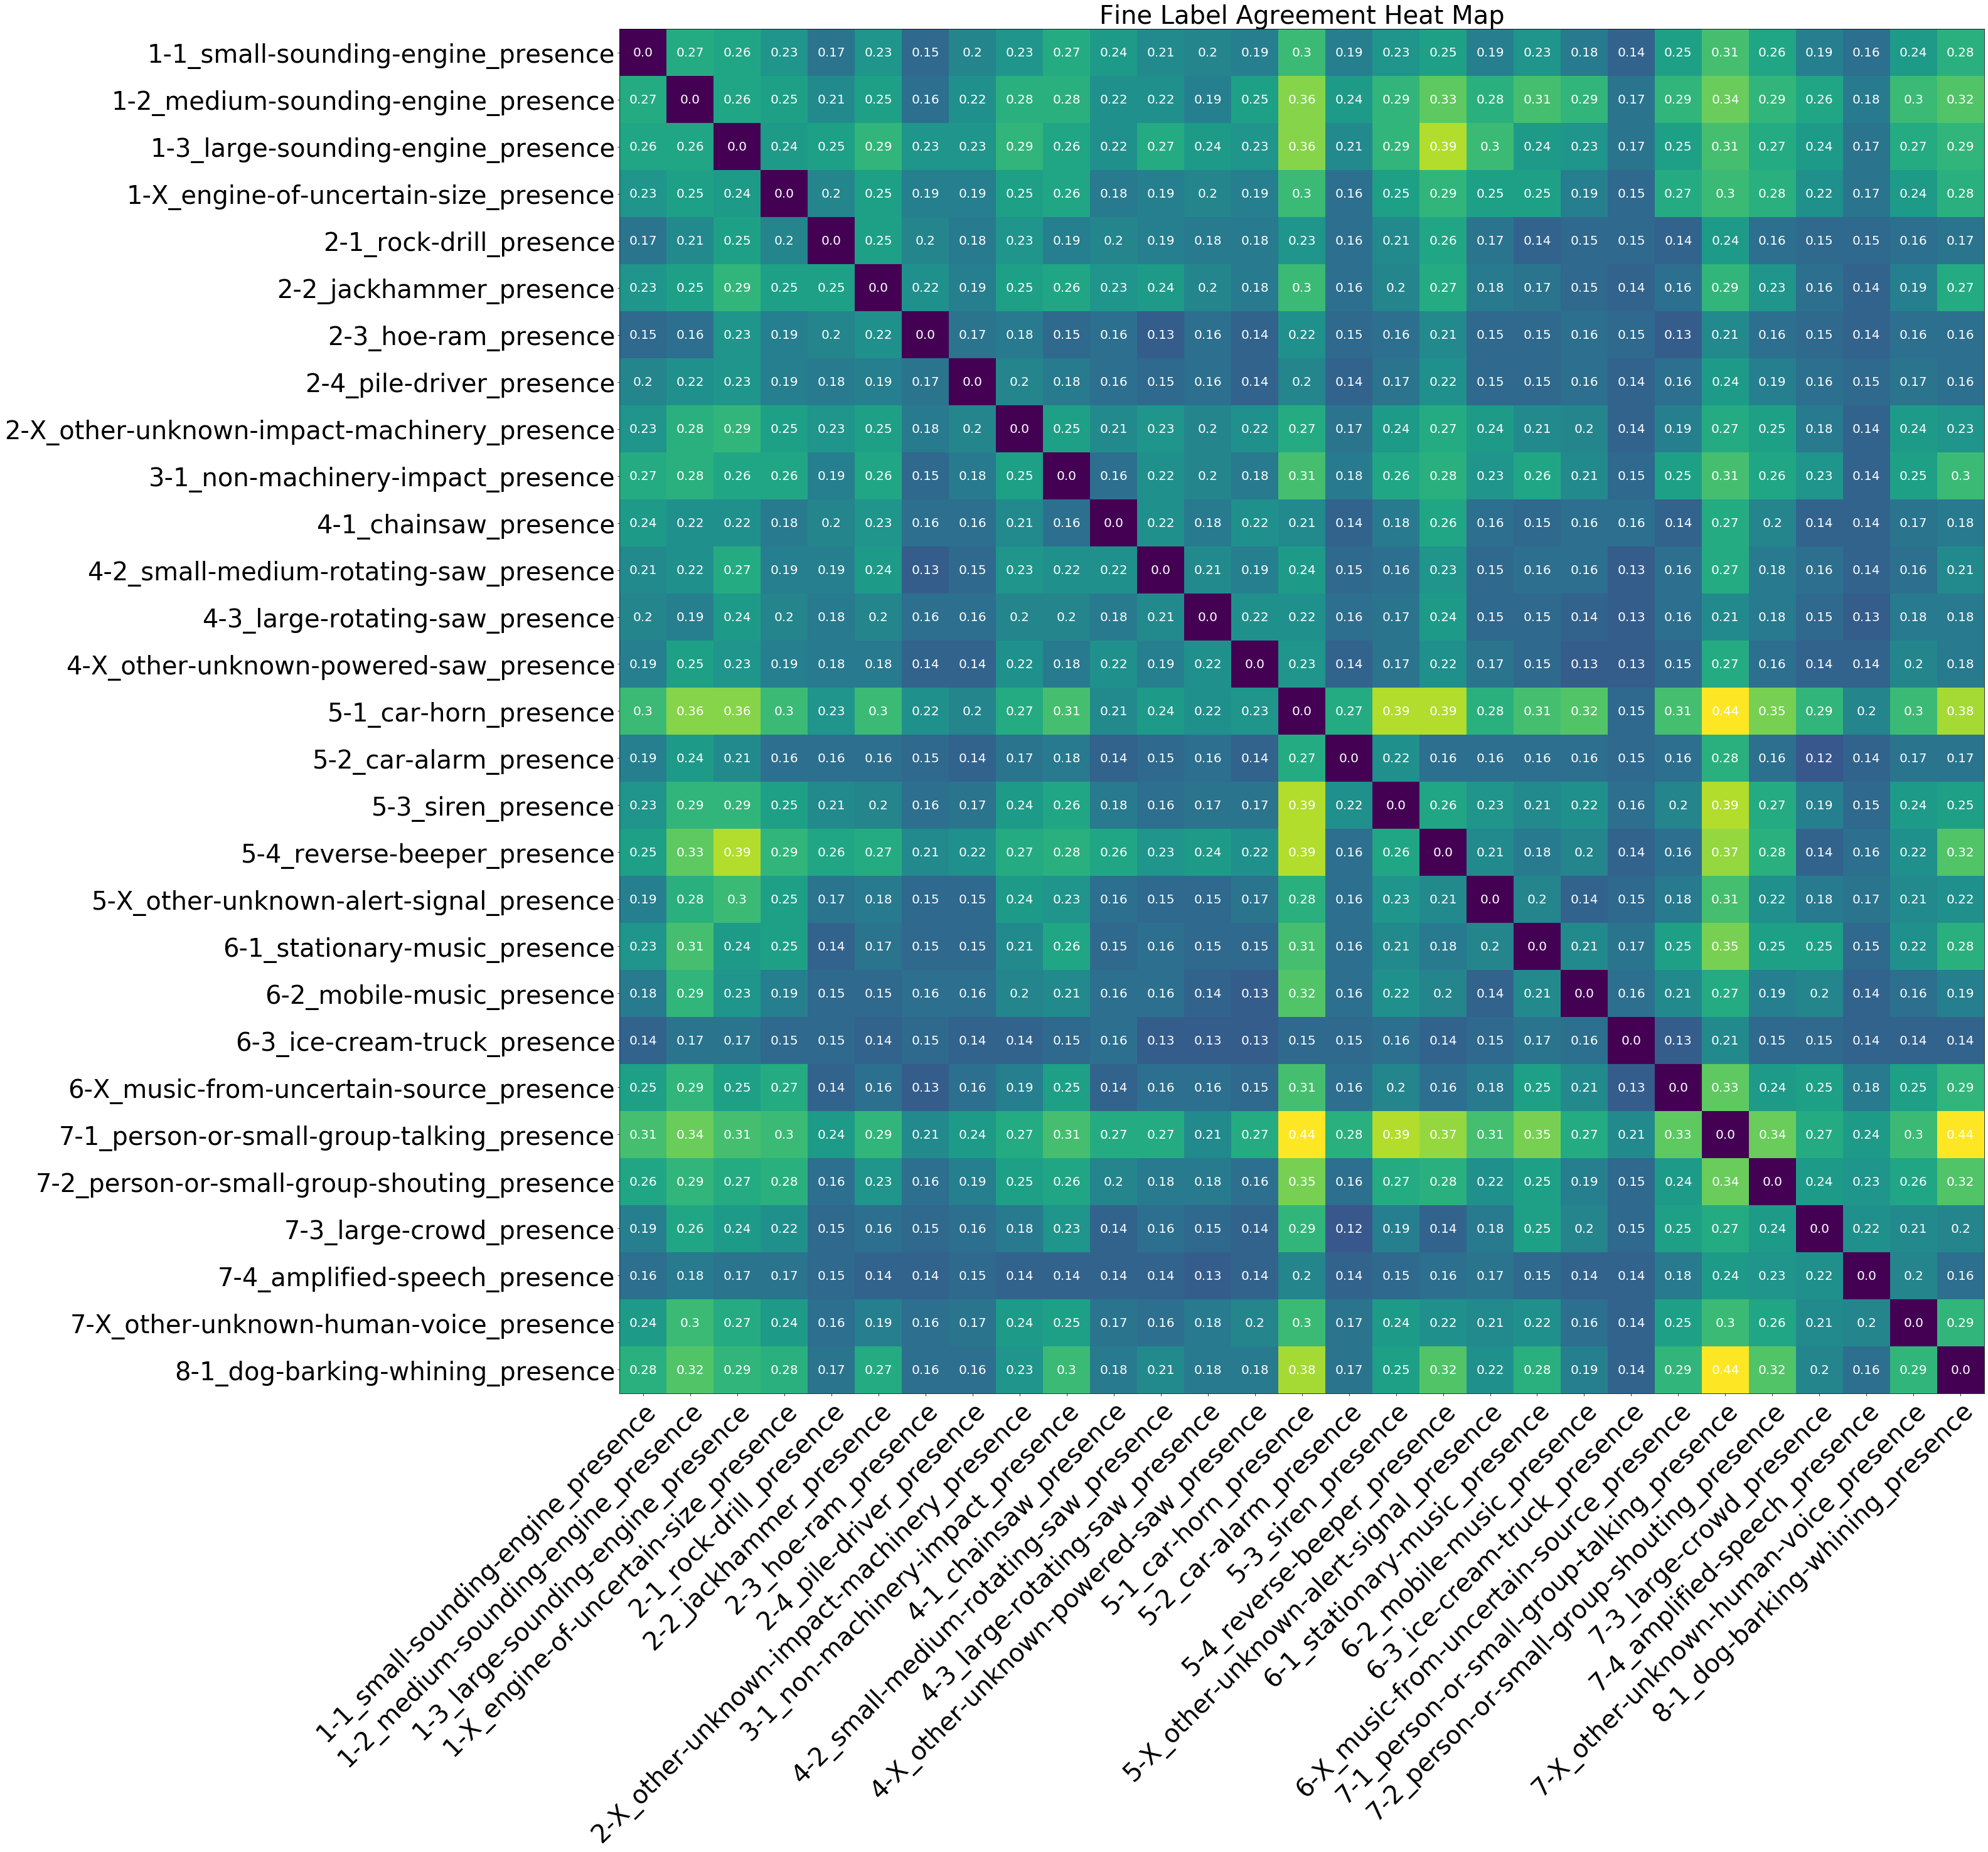

In [12]:
fine_agreement_matrix = get_agreement(fine_labels, df)
heat_map(fine_labels, np.round(fine_agreement_matrix, 2), 40, 40, "Fine Label Agreement Heat Map")